In [ ]:
!pip uninstall scikit-learn
!pip install scikit-learn==0.23.2
!pip install mne==0.24.0
!pip install mne_features==0.1

Found existing installation: scikit-learn 1.0.1
Uninstalling scikit-learn-1.0.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scikit_learn-1.0.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_learn.libs/libgomp-f7e03b3e.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/sklearn/*
Proceed (y/n)? y
  Successfully uninstalled scikit-learn-1.0.1
     |████████████████████████████████| 6.8 MB 6.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.
     |████████████████████████████████| 7.4 MB 7.6 MB/s 


In [ ]:
import os
from mne.preprocessing import ICA

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns

from mne.datasets.sleep_physionet.age import fetch_data


In [ ]:
print(fetch_data)

<function fetch_data at 0x7fe6f4aeddd0>


In [ ]:
ALICE = 1
[alice_files] = fetch_data(subjects=[ALICE], recording=[1])
mapping = {'rectal': 'misc', 'marker': 'misc'}
raw_train = mne.io.read_raw_edf(alice_files[0])
annot_train = mne.read_annotations(alice_files[1])
x=raw_train.set_annotations(annot_train, emit_warning=False)
raw_train.set_channel_types(mapping)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


Extracting EDF parameters from /root/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
rectal, marker
Creating raw.info structure...


<RawEDF | SC4011E0-PSG.edf, 7 x 8406000 (84060.0 s), ~12 kB, data not loaded>

In [ ]:
raw_train.get_channel_types()

['eeg', 'eeg', 'eog', 'resp', 'emg', 'misc', 'misc']

In [ ]:
raw_train.annotations.description.shape  # stages

(126,)

In [ ]:
set(raw_train.get_channel_types())
set(raw_train.annotations.description)
raw_train.get_data().shape[1]/raw_train.info['sfreq']/60/60
set(raw_train.ch_names)

{'Fpz-Cz', 'Pz-Oz', 'horizontal', 'marker', 'oro-nasal', 'rectal', 'submental'}

In [ ]:
raw_train.get_data().shape

(7, 8406000)

Effective window size : 20.480 (s)


<ipython-input-10-6f4001333b9e>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_train.plot_psd()


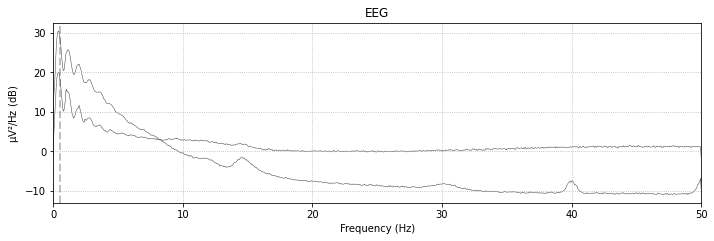

Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


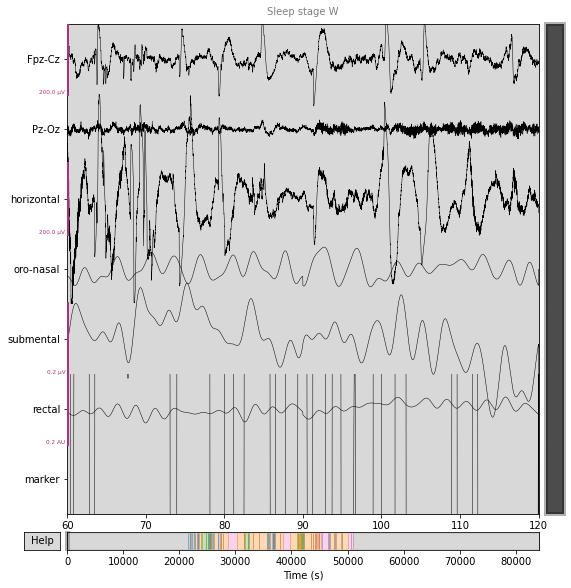

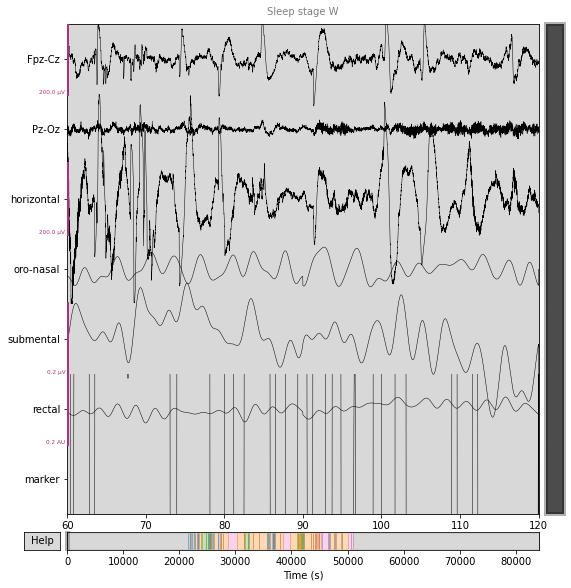

In [ ]:
raw_train.plot_psd()
# plot some data
# scalings were chosen manually to allow for simultaneous visualization of
# different channel types in this specific dataset
raw_train.plot(start=60, duration=60,
               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,
                             misc=1e-1))

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


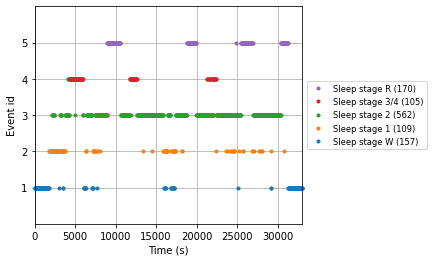

In [ ]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60, annot_train[-2]['onset'] + 30 * 60)

raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# plot events
fig = mne.viz.plot_events(events_train, event_id=event_id,
                          sfreq=raw_train.info['sfreq'],
                          first_samp=events_train[0, 0])


In [ ]:
events_train

array([[1974000,       0,       1],
       [1977000,       0,       1],
       [1980000,       0,       1],
       ...,
       [5274000,       0,       1],
       [5277000,       0,       1],
       [5280000,       0,       1]])

In [ ]:
raw_train.get_data().shape

(7, 8406000)

In [ ]:
raw_train.info['sfreq']

100.0

In [ ]:
tmax = 30. - 1. / raw_train.info['sfreq']
reject_criteria = dict(
                       eeg=150e-6,       # 150 µV
                       eog=250e-6)       # 250 µV
epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None, reject=reject_criteria)

print(epochs_train)


Not setting metadata
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170
 'Sleep stage W': 157>


Loading data for 109 events and 3000 original time points ...
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EE

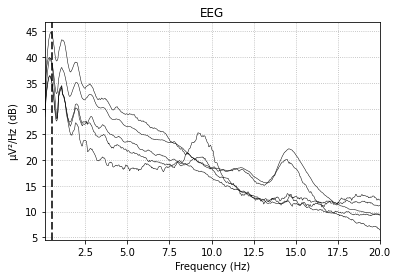

In [ ]:
fig, ax = plt.subplots(ncols=1)
stages = sorted(event_id.keys())  
for stage in stages:
      epochs_train[stage].plot_psd(area_mode=None, ax=ax,fmin=0.1, fmax=20., show=False,average=True, spatial_colors=False)

In [ ]:
epochs_train.get_data().shape

Loading data for 1103 events and 3000 original time points ...
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz', 'Pz-Oz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz', 'Pz-Oz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epoch based on EOG : ['horizontal']
    Rejecting  epoch based on EEG : ['Fpz-Cz']
    Rejecting  epo

(714, 7, 3000)

In [ ]:
x = epochs_train.get_data()[:,:2,:]
y = epochs_train.events[:,2]

features_1 = np.mean(x, axis=2)
features_1.shape

print(len(y))

Loading data for 714 events and 3000 original time points ...
714


In [ ]:
from mne.time_frequency import psd_welch

In [ ]:
# EEG relative power band feature extraction.
def eeg_power_band(epochs):
   
    # specific frequency bands
    
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "beta": [11.5, 15.5],
                  "gama": [15.5, 30]}
    #Compute the power spectral density (PSD) using Welch’s method.
    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    print('psds.shape',psds.shape)
    print('freqs.shape',freqs.shape)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [ ]:
eeg_power_band=eeg_power_band(epochs_train)
eeg_power_band.shape

Loading data for 714 events and 3000 original time points ...
Effective window size : 2.560 (s)
psds.shape (714, 2, 75)
freqs.shape (75,)


(714, 10)

## Good feature STD

In [ ]:
std = np.std(x, axis=2)

In [ ]:
print(std)

[[8.30089825e-06 5.59589890e-06]
 [7.70857194e-06 4.81261000e-06]
 [8.59300193e-06 4.93550816e-06]
 ...
 [8.64932628e-06 8.26852094e-06]
 [8.59626286e-06 5.77979120e-06]
 [1.41903046e-05 6.29731790e-06]]


Sleep stage 1
(68, 2)
Sleep stage 2
(493, 2)
Sleep stage 3/4
(48, 2)
Sleep stage R
(82, 2)
Sleep stage W
(23, 2)


Text(0, 0.5, 'Density')

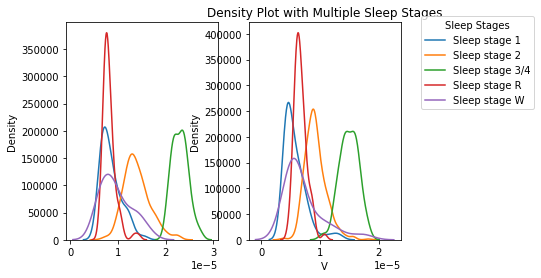

In [ ]:
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(ncols=2)
stages = sorted(event_id.keys())  
for stage in stages:
  print(stage)
  f = std[y==event_id[stage]]
  print(f.shape)
  sns.kdeplot(f[:,0], label = stage, ax=ax1)
  sns.kdeplot(f[:,1], label = stage, ax=ax2)
# Plot formatting
plt.legend(title = 'Sleep Stages', loc='best',bbox_to_anchor=(1.1, 1.05))
plt.title('Density Plot with Multiple Sleep Stages')
plt.xlabel('V')
plt.ylabel('Density')

In [ ]:
max = np.max(x, axis=2)


Sleep stage 1
(68, 2)
Sleep stage 2
(493, 2)
Sleep stage 3/4
(48, 2)
Sleep stage R
(82, 2)
Sleep stage W
(23, 2)


Text(0, 0.5, 'Density')

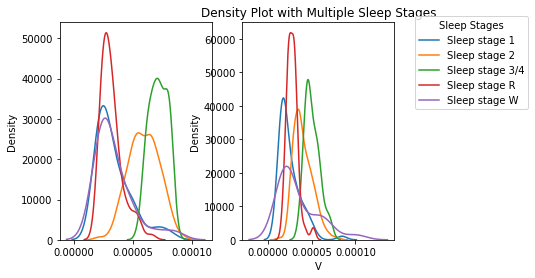

In [ ]:
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(ncols=2)
stages = sorted(event_id.keys())  
for stage in stages:
  print(stage)
  f = max[y==event_id[stage]]
  print(f.shape)
  sns.kdeplot(f[:,0], label = stage, ax=ax1)
  sns.kdeplot(f[:,1], label = stage, ax=ax2)
# Plot formatting
plt.legend(title = 'Sleep Stages', loc='best',bbox_to_anchor=(1.1, 1.05))
plt.title('Density Plot with Multiple Sleep Stages')
plt.xlabel('V')
plt.ylabel('Density')

In [ ]:
var = np.var(x, axis=2)
print(var.shape)

(714, 2)


Sleep stage 1
(68, 2)
Sleep stage 2
(493, 2)
Sleep stage 3/4
(48, 2)
Sleep stage R
(82, 2)
Sleep stage W
(23, 2)


Text(0, 0.5, 'Density')

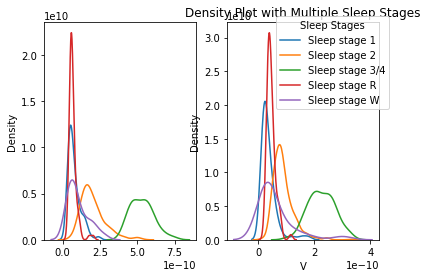

In [ ]:
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(ncols=2)
stages = sorted(event_id.keys())  
for stage in stages:
  print(stage)
  f = var[y==event_id[stage]]
  print(f.shape)
  sns.kdeplot(f[:,0], label = stage, ax=ax1)
  sns.kdeplot(f[:,1], label = stage, ax=ax2)
# Plot formatting
plt.legend(title = 'Sleep Stages', loc='best',bbox_to_anchor=(1.1, 1.05))
plt.title('Density Plot with Multiple Sleep Stages')
plt.xlabel('V')
plt.ylabel('Density')

## Good Feature as Peak-to-peak (PTP) amplitude 

In [ ]:
# Peak-to-peak (PTP) amplitude of the data (per channel)
def compute_ptp_amp(data):
    
    return np.ptp(data, axis=-1)

In [ ]:
compute_ptp_amp = compute_ptp_amp(x) 

Sleep stage 1
(68, 2)
Sleep stage 2
(493, 2)
Sleep stage 3/4
(48, 2)
Sleep stage R
(82, 2)
Sleep stage W
(23, 2)


Text(0, 0.5, 'Density')

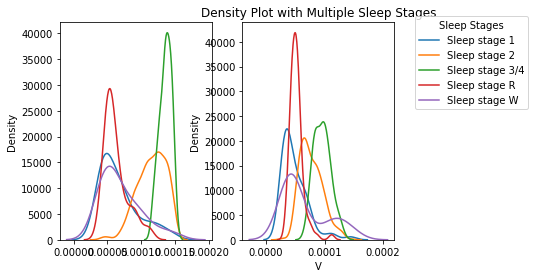

In [ ]:
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(ncols=2)
stages = sorted(event_id.keys())  
for stage in stages:
  print(stage)
  f = compute_ptp_amp[y==event_id[stage]]
  print(f.shape)
  sns.kdeplot(f[:,0], label = stage, ax=ax1)
  sns.kdeplot(f[:,1], label = stage, ax=ax2)
# Plot formatting
plt.legend(title = 'Sleep Stages', loc='best',bbox_to_anchor=(1.1, 1.05))
plt.title('Density Plot with Multiple Sleep Stages')
plt.xlabel('V')
plt.ylabel('Density')

## Good Feature as Root-mean squared

In [ ]:
# Root-mean squared value of the data (per channel)
def compute_rms(data):
   
    return np.sqrt(np.mean(np.power(data, 2), axis=-1))

In [ ]:
compute_rms = compute_rms(x)

Sleep stage 1
(68, 2)
Sleep stage 2
(493, 2)
Sleep stage 3/4
(48, 2)
Sleep stage R
(82, 2)
Sleep stage W
(23, 2)


Text(0, 0.5, 'Density')

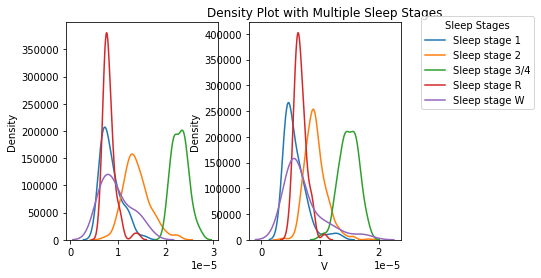

In [ ]:
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(ncols=2)
stages = sorted(event_id.keys())  
for stage in stages:
  print(stage)
  f = compute_rms[y==event_id[stage]]
  print(f.shape)
  sns.kdeplot(f[:,0], label = stage, ax=ax1)
  sns.kdeplot(f[:,1], label = stage, ax=ax2)
# Plot formatting
plt.legend(title = 'Sleep Stages', loc='best',bbox_to_anchor=(1.1, 1.05))
plt.title('Density Plot with Multiple Sleep Stages')
plt.xlabel('V')
plt.ylabel('Density')

In [ ]:
# Quantile of the data (per channel)
def compute_quantile(data, q=0.5):
    
    return np.ravel(np.quantile(data, q, axis=-1), order='F')

In [ ]:
first_quantile=compute_quantile(x, q=0.25)
print(first_quantile.shape)

(1428,)


In [ ]:
second_quantile=compute_quantile(x, q=0.5)

## Baaaad Feature as Kurtosis



In [ ]:
third_quantile=compute_quantile(x, q=0.75)

In [ ]:
from scipy import stats

In [ ]:
# Kurtosis of the data (per channel)
def compute_kurtosis(data):
    
    ndim = data.ndim
    return stats.kurtosis(data, axis=ndim - 1, fisher=False)

In [ ]:
kurtosis=compute_kurtosis(x)

Sleep stage 1
(68, 2)
Sleep stage 2
(493, 2)
Sleep stage 3/4
(48, 2)
Sleep stage R
(82, 2)
Sleep stage W
(23, 2)


Text(0, 0.5, 'Density')

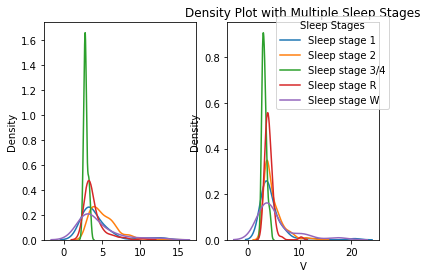

In [ ]:
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(ncols=2)
stages = sorted(event_id.keys())  
for stage in stages:
  print(stage)
  f = kurtosis[y==event_id[stage]]
  print(f.shape)
  sns.kdeplot(f[:,0], label = stage, ax=ax1)
  sns.kdeplot(f[:,1], label = stage, ax=ax2)
# Plot formatting
plt.legend(title = 'Sleep Stages', loc='best',bbox_to_anchor=(1.1, 1.05))
plt.title('Density Plot with Multiple Sleep Stages')
plt.xlabel('V')
plt.ylabel('Density')

## baaad feature  Skewness

In [ ]:
# Skewness of the data (per channel)
def compute_skewness(data):
  
    ndim = data.ndim
    return stats.skew(data, axis=ndim - 1)

In [ ]:
skewness = compute_skewness(x)

Sleep stage 1
(68, 2)
Sleep stage 2
(493, 2)
Sleep stage 3/4
(48, 2)
Sleep stage R
(82, 2)
Sleep stage W
(23, 2)


Text(0, 0.5, 'Density')

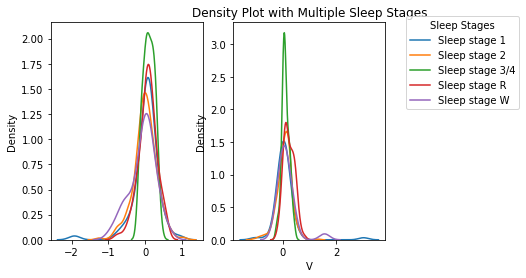

In [ ]:
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(ncols=2)
stages = sorted(event_id.keys())  
for stage in stages:
  print(stage)
  f = skewness[y==event_id[stage]]
  print(f.shape)
  sns.kdeplot(f[:,0], label = stage, ax=ax1)
  sns.kdeplot(f[:,1], label = stage, ax=ax2)
# Plot formatting
plt.legend(title = 'Sleep Stages', loc='best',bbox_to_anchor=(1.1, 1.05))
plt.title('Density Plot with Multiple Sleep Stages')
plt.xlabel('V')
plt.ylabel('Density')

In [ ]:
from itertools import chain
flatten_compute_ptp_amp = list(chain.from_iterable(compute_ptp_amp))
flatten_compute_rms = list(chain.from_iterable(compute_rms))
flatten_max = list(chain.from_iterable(max))
flatten_std = list(chain.from_iterable(std))
flatten_var = list(chain.from_iterable(var))


In [ ]:
print(flatten_compute_ptp_amp)

[5.3304029304029306e-05, 4.9694749694749696e-05, 5.041465201465202e-05, 4.12014652014652e-05, 5.4499633699633696e-05, 3.451526251526251e-05, 5.2905494505494505e-05, 3.424420024420024e-05, 5.6093772893772894e-05, 3.207570207570207e-05, 5.5396336996337e-05, 3.035897435897436e-05, 6.964395604395604e-05, 2.566056166056166e-05, 6.057728937728938e-05, 4.0388278388278386e-05, 0.0001130842490842491, 6.722344322344322e-05, 9.574798534798534e-05, 5.529670329670329e-05, 0.00010222417582417582, 7.174114774114774e-05, 0.00012872673992673993, 7.689133089133089e-05, 0.00011477802197802199, 8.439072039072038e-05, 0.00010401758241758243, 8.574603174603174e-05, 0.00011328351648351648, 8.673992673992673e-05, 0.00014984908424908427, 9.234188034188033e-05, 0.00012563809523809523, 6.198290598290598e-05, 4.154725274725275e-05, 5.629059829059829e-05, 5.121172161172161e-05, 3.731623931623932e-05, 4.104908424908425e-05, 3.2075702075702066e-05, 3.825934065934066e-05, 3.135286935286935e-05, 4.8222710622710626e-05

In [ ]:
flatten_compute_ptp_amp_X = flatten_compute_ptp_amp[::2] # Elements from list1 starting from 0 iterating by 2
flatten_compute_ptp_amp_Y = flatten_compute_ptp_amp[1::2] # Elements from list1 starting from 1 iterating by 2


In [ ]:
flatten_compute_rms_X = flatten_compute_rms[::2] # Elements from list1 starting from 0 iterating by 2
flatten_compute_rms_Y = flatten_compute_rms[1::2] # Elements from list1 starting from 1 iterating by 2

In [ ]:
flatten_max_X = flatten_max[::2] # Elements from list1 starting from 0 iterating by 2
flatten_max_Y = flatten_max[1::2] # Elements from list1 starting from 1 iterating by 2

In [ ]:
flatten_std_X = flatten_std[::2] # Elements from list1 starting from 0 iterating by 2
flatten_std_Y = flatten_std[1::2] # Elements from list1 starting from 1 iterating by 2

In [ ]:
flatten_var_X = flatten_var[::2] # Elements from list1 starting from 0 iterating by 2
flatten_var_Y = flatten_var[1::2] # Elements from list1 starting from 1 iterating by 2

In [ ]:
# import pandas as pd
import pandas as pd
  
# Calling DataFrame constructor after zipping
# both lists, with columns specified
X_Sleep_Data = pd.DataFrame(list(zip(   flatten_var_X ,flatten_var_Y , flatten_std_X, flatten_std_Y, flatten_max_X ,flatten_max_Y,
                           flatten_compute_rms_X, flatten_compute_rms_Y , flatten_compute_ptp_amp_X  ,flatten_compute_ptp_amp_Y)),
               columns =[  'var_x ' , 'var_y ' ,'std_x' ,'std_y' , 'max_x' , 'max_y' 
                         ,'compute_rms_x','compute_rms_y','compute_ptp_amp_x ','compute_ptp_amp_y '])
X_Sleep_Data

,var_x,var_y,std_x,std_y,max_x,max_y,compute_rms_x,compute_rms_y,compute_ptp_amp_x,compute_ptp_amp_y
0,6.890491e-11,3.131408e-11,0.000008,0.000006,0.000026,0.000019,0.000008,0.000006,0.000053,0.000050
1,5.942208e-11,2.316122e-11,0.000008,0.000005,0.000024,0.000021,0.000008,0.000005,0.000050,0.000041
2,7.383968e-11,2.435924e-11,0.000009,0.000005,0.000027,0.000015,0.000009,0.000005,0.000054,0.000035
3,5.019783e-11,1.988617e-11,0.000007,0.000004,0.000030,0.000017,0.000007,0.000004,0.000053,0.000034
4,1.023031e-10,1.808286e-11,0.000010,0.000004,0.000026,0.000018,0.000010,0.000004,0.000056,0.000032
...,...,...,...,...,...,...,...,...,...,...
709,5.908264e-11,3.997452e-11,0.000008,0.000006,0.000032,0.000028,0.000008,0.000006,0.000056,0.000052
710,4.218616e-11,2.657686e-11,0.000006,0.000005,0.000022,0.000020,0.000006,0.000005,0.000047,0.000039
711,7.481085e-11,6.836844e-11,0.000009,0.000008,0.000037,0.000025,0.000009,0.000008,0.000081,0.000051
712,7.389574e-11,3.340599e-11,0.000009,0.000006,0.000028,0.000024,0.000009,0.000006,0.000065,0.000049


In [ ]:
# def duplicate(testList, n):
#     yy = 0
#     x = len(testList)
#     newList=[]
#     while yy < x:
#         for z in range (0, n):
#             newList.append(testList[yy])
#         yy = yy + 1
#     return newList

# Y=duplicate(y, 2)
# len(Y)

In [ ]:

y.shape

(714,)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_Sleep_Data, y, test_size=0.33, random_state=42)
type(X_train)

In [ ]:
from sklearn import svm # for suport vector machine algorithm
from sklearn import metrics # for checking the model accuracy

model = svm.SVC() # select the svm algorithm

# we train the algorithm with training data and training output
model.fit(X_train, y_train)

# we pass the testing data to the stored algorithm to predict the outcome
predicted_SVM = model.predict(X_test)
print('The accuracy of the SVM is: ', '%',metrics.accuracy_score(predicted_SVM, y_test)*100) # we check the accuracy of the algorithm
#we pass the predicted output by the model and the actual output

The accuracy of the SVM is:  % 72.03389830508475


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
model.fit(X_train, y_train)

#Predict Output
predicted_KNN= model.predict(X_test) 

print('The accuracy of the KNN is: ', '%',metrics.accuracy_score(predicted_KNN, y_test)*100)


The accuracy of the KNN is:  % 81.35593220338984


In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?                          
print('The accuracy of the DecisionTreeClassifier is: ', '%',metrics.accuracy_score( y_pred,y_test)*100)


The accuracy of the DecisionTreeClassifier is:  % 87.28813559322035


In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?                          
print('The accuracy of the DecisionTreeClassifier is: ', '%',metrics.accuracy_score(y_pred, y_test)*100)


The accuracy of the DecisionTreeClassifier is:  % 87.28813559322035
